In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import requests, censusdata, zipfile
import re
import os
import sys
import urllib, json, requests
from os import path
from pathlib import Path
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## 1. County-Level COVID-19 Case Data

In [2]:
raw_dir = "../raw_data/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"
start_date_file = "03-23-2020.csv"

In [3]:
# Create DataFrame of confirmed cases by county and date

data_list = []

for file in os.listdir(raw_dir):
    if file[-4:] == ".csv" and file >= start_date_file:
        entry = pd.read_csv(raw_dir + file)
        entry = entry.loc[(entry.Country_Region == "US") & (entry.FIPS.apply(str).str.len() == 7), ["FIPS", "Confirmed"]].astype(int)
        entry = entry.set_index("FIPS").rename(columns = {"Confirmed": file[:-4]})
        entry = entry[~entry.index.duplicated()]
        data_list.append(entry)
        
confirmed = pd.concat(data_list, axis = 1)

In [4]:
# Create DataFrame of new confirmed cases

new_confirmed = confirmed.diff(axis = 1)
new_confirmed[start_date_file[:-4]] = confirmed[start_date_file[:-4]]

In [5]:
new_confirmed.head()

,03-23-2020,03-24-2020,03-25-2020,03-26-2020,03-27-2020,03-28-2020,03-29-2020,03-30-2020,03-31-2020,04-01-2020,...,11-06-2020,11-07-2020,11-08-2020,11-09-2020,11-10-2020,11-11-2020,11-12-2020,11-13-2020,11-14-2020,11-15-2020
FIPS,,,,,,,,,,,,,,,,,,,,,
10001,6.0,4.0,4.0,3.0,4.0,4.0,0.0,2.0,7.0,7.0,...,36.0,24.0,37.0,34.0,17.0,45.0,27.0,55.0,71.0,17.0
10003,44.0,27.0,8.0,7.0,19.0,25.0,11.0,15.0,41.0,29.0,...,179.0,146.0,240.0,210.0,131.0,130.0,125.0,313.0,228.0,288.0
10005,18.0,5.0,3.0,1.0,10.0,22.0,7.0,15.0,7.0,13.0,...,66.0,53.0,67.0,61.0,56.0,55.0,52.0,102.0,78.0,103.0
11001,120.0,21.0,46.0,44.0,40.0,33.0,38.0,59.0,94.0,91.0,...,110.0,99.0,110.0,86.0,86.0,206.0,128.0,159.0,148.0,163.0
12001,36.0,1.0,8.0,4.0,8.0,10.0,4.0,8.0,8.0,3.0,...,51.0,35.0,41.0,138.0,86.0,103.0,104.0,77.0,20.0,89.0


In [6]:
new_confirmed.to_csv("../processed_data/new_confirmed.csv")

## 2. US county demographic data EDA

#### 2.1 Pull downloaded Kaggle data (requires auth) 
Basic county-level demographic data from JHU and US Census was downloaded from Kaggle to a CSV since download requires username / password authentication. The data contains the unique FIPS code, county / state names, male and female populations, median county age, as well as the latitude and longitude of the center of the county.

In [7]:
raw_dir = Path('../raw_data/')
processed_dir = Path('../processed_data/')

assert(raw_dir.exists() & processed_dir.exists()), 'data directories not valid'

kaggle_demos = pd.read_csv(raw_dir/'us_county.csv')
kaggle_demos.head()

,fips,county,state,state_code,male,female,median_age,population,female_percentage,lat,long
0,1001,Autauga County,Alabama,AL,26874,28326,37.8,55200,51.315217,32.534923,-86.642730
1,1003,Baldwin County,Alabama,AL,101188,106919,42.8,208107,51.376936,30.727479,-87.722564
2,1005,Barbour County,Alabama,AL,13697,12085,39.9,25782,46.873788,31.869581,-85.393210
3,1007,Bibb County,Alabama,AL,12152,10375,39.9,22527,46.055844,32.998628,-87.126475
4,1009,Blount County,Alabama,AL,28434,29211,40.8,57645,50.673953,33.980869,-86.567380


#### 2.2 Request IHME health data

Some additional health data was downloaded from the Institute for Health Metrics and Evaluation (IHME). The data contains time series records of mortality risk and life expectancy measures across every county for several age ranges dating back to the 1980s. We cleaned and standardized this data to only include the most recent sample of county average life expectancy at birth and mortality risk for the 65 to 85 year old population (the most vulnerable to the effects of COVID-19). The data also includes a FIPS code.

In [8]:
if 'ihme_health.csv' not in [_.name for _ in raw_dir.glob('*')]:
    h_url = 'http://ghdx.healthdata.org/sites/default/files/record-attached-files/'
    h_file = 'IHME_USA_COUNTY_LE_MORTALITY_RISK_1980_2014_NATIONAL_STATES_DC_CSV.zip'
    r = requests.get(h_url+h_file, stream=True)
    with open(raw_dir/'ihme_health.zip', 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)
    with zipfile.ZipFile(raw_dir/'ihme_health.zip', 'r') as zip_ref:
        zip_ref.extractall(raw_dir/'imhe_health/')
    health_pth = Path(raw_dir/'imhe_health/')
    assert health_pth.exists(), 'no health files found'
    files = health_pth.glob('*.csv')
    
    health_dfs = []
    for f in files:
        try:
            df = pd.read_csv(f)
            max_year = df.year_id.max()
            # logic to get single rows for pivot table
            df = df[(df.year_id == max_year) & (df.sex == "Both") \
                    & ((df.age_name == "0") | (df.age_name == "65 to 85"))]
            pvt = pd.pivot_table(df, values = 'val', columns = 'measure_name',
                    index=['FIPS', 'location_name']).reset_index()
            health_dfs.append(pvt)
        except Exception as e:
            print(e); continue
            
    health = pd.concat([_ for _ in health_dfs if _.shape[0] > 1])
    health.to_csv(raw_dir/'ihme_health.csv')
else:
    health = pd.read_csv(raw_dir/'ihme_health.csv')

#### 2.3 Census income data

We downloaded county-level income data from the most recent Census survey (2018) and processed the data to find the estimated number of impoverished people in each county, as well as the median household income. The data again includes a FIPS code.

In [9]:
r = requests.get('https://www2.census.gov/programs-surveys/saipe/datasets/2016/2016-state-and-county/est16all.txt')
t = r.text

lines = t.split('\n')
income_dict = {}
for l in lines:
    name = l[193:238].strip()
    if name == '': continue
    fin_demos = {
        'fips_state': l[0:2].strip(),
        'fips_county': l[3:6].strip(),
        'all_poverty': l[7:15].strip(),
        'median_hh_income': l[133:139].strip()
    }
    income_dict[name] = fin_demos

income = pd.DataFrame(income_dict).T
def fix_fips(s):
    if len(s) == 3: return s
    elif len(s) == 2: return f'0{s}'
    else: return f'00{s}'
    
# fix erros in Kalawao county
income = income.replace('.', np.nan)
income['all_poverty'] = income.all_poverty.astype(float)
income['median_hh_income'] = income.median_hh_income.astype(float)

income['fips_county_pad'] = income.fips_county.map(fix_fips)
income['fips'] = (income.fips_state + income.fips_county_pad).astype(int)
income.head()

,fips_state,fips_county,all_poverty,median_hh_income,fips_county_pad,fips
United States,00,0,44268996.0,57617.0,000,0
Alabama,01,0,814197.0,46309.0,000,1000
Autauga County,01,1,7444.0,54487.0,001,1001
Baldwin County,13,9,10273.0,40683.0,009,13009
Barbour County,54,1,3514.0,36485.0,001,54001


#### 2.4 Land area

Finally, we pull census data for the land area (in square miles) of each county as of 2010, which is the most recent year available. The data includes the FIPS code.

In [10]:
landvar = 'LND110210D'
land = pd.read_csv(raw_dir/'LND01.csv')[['STCOU', landvar]].rename(
    columns={'STCOU':'fips', landvar:'sq_miles'})
land.head()

,fips,sq_miles
0,0,3531905.43
1,1000,50645.33
2,1001,594.44
3,1003,1589.78
4,1005,884.88


#### 2.5 Merge

We merge all of these datasets on FIPS code.

In [11]:
demos = pd.merge(
    kaggle_demos, health.set_index('FIPS')[['Life expectancy', 'Mortality risk']],
    left_on='fips', right_index=True).merge(
        income.set_index('fips')[['all_poverty', 'median_hh_income']],
        left_on='fips', right_index=True).merge(
            land.set_index('fips'), left_on='fips', right_index=True)

def fix_colname(s): return s.lower().strip().replace(' ', '_')
demos.columns = [fix_colname(_) for _ in demos.columns]
demos.head()

,fips,county,state,state_code,male,female,median_age,population,female_percentage,lat,long,life_expectancy,mortality_risk,all_poverty,median_hh_income,sq_miles
0,1001,Autauga County,Alabama,AL,26874,28326,37.8,55200,51.315217,32.534923,-86.642730,75.668023,58.373616,7444.0,54487.0,594.44
5,1011,Bullock County,Alabama,AL,5663,4689,39.6,10352,45.295595,32.100525,-85.715679,73.859057,56.831543,2841.0,34278.0,622.81
10,1021,Chilton County,Alabama,AL,21672,22258,38.6,43930,50.666970,32.847867,-86.718790,74.527386,59.625260,7960.0,44188.0,692.85
16,1033,Colbert County,Alabama,AL,26075,28420,42.7,54495,52.151574,34.700471,-87.804928,75.071790,58.774889,8982.0,46572.0,592.62
17,1035,Conecuh County,Alabama,AL,6037,6477,44.8,12514,51.758031,31.429237,-86.993662,74.050503,56.796792,3464.0,29758.0,850.16


#### 2.6 Enrich

We engineer two features that we intuitively believe may have some relationship to the spread of COVID-19. The first is related to the rate at which the population is impoverished. We have estimates from Census of the total number of inhabitants living below the poverty line, but here we standardize by the population of the county to arrive at an estimate of the percent of the county that is impoverished. We also use the population variable and the estimated land area variable to determine the population density in terms of inhabitants per square mile.

In [12]:
demos['pct_impoverished'] = demos.all_poverty.div(demos.population)
demos['pop_density'] = demos.population.div(demos.sq_miles)

In [13]:
demos.to_csv(processed_dir/'demographic_data.csv', index=False)

#### 2.7 Data Understanding
We'll visualize some key features to get a better understanding of the demographic data.

In [14]:
features = 'median_age female_percentage life_expectancy mortality_risk \
median_hh_income pct_impoverished pop_density'.split()

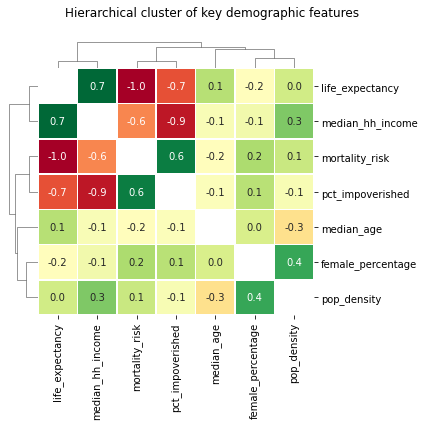

In [15]:
cm = sns.clustermap(demos[features].corr(method='spearman'), annot=True, fmt='.1f', linewidths=0.5,
              mask=np.eye(len(features)), cmap='RdYlGn', dendrogram_ratio=.1,
              figsize=(6,6), cbar=False)
cm.fig.subplots_adjust(top=.9)
cm.cax.set_visible(False)
cm.fig.suptitle('Hierarchical cluster of key demographic features')
plt.show()

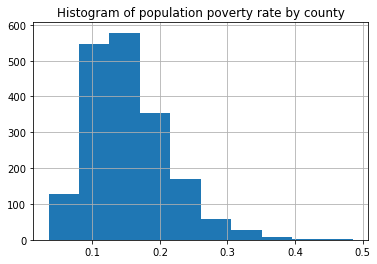

In [16]:
demos.pct_impoverished.hist()
plt.title('Histogram of population poverty rate by county')
plt.show()

R2 score of poverty and mortality risk is 0.322


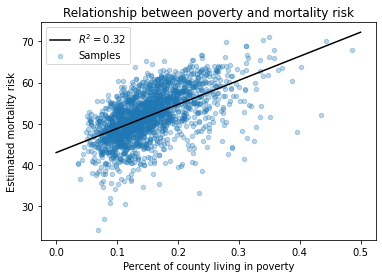

In [17]:
demos.plot.scatter('pct_impoverished', 'mortality_risk', alpha=0.3)
plt.xlabel('Percent of county living in poverty')
plt.ylabel('Estimated mortality risk')
plt.title('Relationship between poverty and mortality risk')

X = demos.dropna()
lm = LinearRegression().fit(X.pct_impoverished.values.reshape(-1,1), X.mortality_risk)
xs = np.linspace(0, 0.5)
ys = lm.predict(xs.reshape(-1,1))
r2 = lm.score(X.pct_impoverished.values.reshape(-1,1), X.mortality_risk)
print(f"R2 score of poverty and mortality risk is {r2:.3f}")
plt.plot(xs,ys, color='black')
plt.legend([f'$R^2 = {r2:.2f}$', 'Samples'])
plt.show()

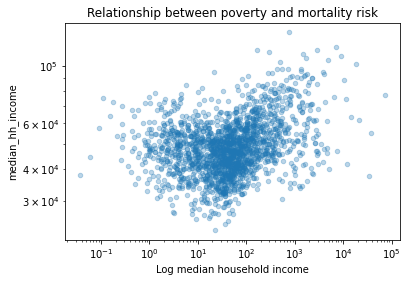

In [18]:
demos.plot.scatter('pop_density', 'median_hh_income', alpha=0.3)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Log population density')
plt.xlabel('Log median household income')
plt.title('Relationship between poverty and mortality risk'); plt.show()

## 3. Protest Data

#### 3.1 Data Cleaning

In [ ]:
protest_data = pd.read_csv("../raw_data/protest_AECLD.csv")

In [ ]:
empty_search = r'no\ report'
empty = protest_data.NOTES.str.findall(empty_search)

count_empty = 0
for i in empty:
    if i:
        count_empty = count_empty + 1

count_empty

In [ ]:
sr = r'\[size=(.*)\]'
nums = r'\d+|few\ dozen*|few\ hundred*|few\ thousand*|several\ dozen*|several\ hundred*|several\ thousand*|dozen*|hundred*|thousand*'
sizes = protest_data.NOTES.str.findall(sr)
unique_sizes = [list(x) for x in set(tuple(x) for x in sizes)]
size_temp_df = pd.DataFrame([''.join(x) for x in sizes], columns = ['string'])
size_labs = size_temp_df.string.str.findall(nums)

count_recovered = 0
for i in size_labs:
    if i:
        count_recovered = count_recovered + 1

count_recovered

print(f'{count_recovered} of the {len(protest_data) - count_empty} non-emtpy records were retrieved.')

size_cleaned = [None] * len(protest_data)

dozen = 12
few_dozen = 50
hundred = 100
few_hundred = 500
thousand = 1000
few_thousand = 5000

for ii in range(len(size_labs)):
    
    vals = size_labs[ii]
    
    if any(st == "few dozen" for st in vals) | any(st == "several dozen" for st in vals):
        size_cleaned[ii] = few_dozen
    elif any(st == "few hundred" for st in vals) | any(st == "several hundred" for st in vals):
        size_cleaned[ii] = few_hundred
    elif any(st == "few thousand" for st in vals) | any(st == "several thousand" for st in vals):
        size_cleaned[ii] = few_thousand
    elif any(st == "dozen" for st in vals):
        size_cleaned[ii] = dozen
    elif any(st == "hundred" for st in vals):
        size_cleaned[ii] = hundred
    elif any(st == "thousand" for st in vals):
        size_cleaned[ii] = thousand
    else:
        size_cleaned[ii] = np.mean(np.array(vals, dtype=np.float32).astype(np.float))

print(len(size_cleaned))
protest_data["size"] = size_cleaned

In [ ]:
protest_data["99 or less"] = (protest_data["size"] <= 99) * 1
protest_data["100 to 499"] = ((protest_data["size"] > 99) &(protest_data["size"] <= 499)) * 1
protest_data["500 to 999"] = ((protest_data["size"] > 499) & (protest_data["size"] <= 999)) * 1
protest_data["1000 to 4999"] = ((protest_data["size"] > 999) & (protest_data["size"] <= 4999)) * 1
protest_data["more than 4999"] = ((protest_data["size"] > 4999)) * 1
protest_data

sizes = ["99 or less", "100 to 499", "500 to 999", "1000 to 4999", "more than 4999"]

In [ ]:
convert={'fips': lambda x: str(x), 'EVENT_DATE': lambda x: pd.to_datetime(x)}
protest_fips = pd.read_csv("../processed_data/protests_fips.csv", converters = convert)
protest_fips

In [ ]:
protest_data.EVENT_DATE = pd.to_datetime(protest_data.EVENT_DATE)
protest_data = protest_data.replace('', np.nan)
protest_fips["EVENT_DATE"] = pd.to_datetime(protest_fips.EVENT_DATE)
protest_data_full = protest_data.join(protest_fips.fips,  how = "left")
var_list = ["fips", "EVENT_DATE","99 or less", "100 to 499", "500 to 999", "1000 to 4999", "more than 4999"]
protest_data_full
protest_data_clean = protest_data_full[var_list]
protest_data_clean["unknown"] = (protest_data_clean[["99 or less", "100 to 499","500 to 999", "1000 to 4999", "more than 4999"]].sum(axis = 1) == 0).astype(int)
protest_data_clean.dtypes

In [ ]:
protest_data_clean.to_csv("../processed_data/protests.csv", index = False)

#### 3.2 FIPS Codes

In [ ]:
fips_codes = []

for i in range(len(protest_data)):
    
    temp_url = "https://geo.fcc.gov/api/census/area?lat=" +str(protest_data.LATITUDE[i]) +"&lon=" + str(protest_data.LONGITUDE[i])+ "&format=json"
    
    with urllib.request.urlopen(temp_url) as url:
        data = json.loads(url.read().decode())
    
    if not data["results"]:
        fips_codes.append("")
    else:
        fips_codes.append(data["results"][0]["county_fips"])

In [ ]:
protest_data["fips_county"] = fips_codes
protest_data["fips_county"] = protest_data.fips_county.astype(str)

#### 3.3 Visualization and EDA

In [18]:
convert={'fips': lambda x: str(x), 'EVENT_DATE': lambda x: pd.to_datetime(x)}
protest_df = pd.read_csv("../processed_data/protests.csv", converters = convert)
protest_df

,fips,EVENT_DATE,99 or less,100 to 499,500 to 999,1000 to 4999,more than 4999,unknown
0,24510,2020-05-24,0,0,0,0,0,1
1,17199,2020-05-24,1,0,0,0,0,0
2,39099,2020-05-24,0,0,0,0,0,1
3,34023,2020-05-24,1,0,0,0,0,0
4,36031,2020-05-24,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
16875,28049,2020-11-07,0,0,0,0,0,1
16876,13051,2020-11-07,1,0,0,0,0,0
16877,18167,2020-11-07,0,0,0,0,0,1
16878,10003,2020-11-07,0,0,0,0,0,1


In [19]:
## Data cleaning for plotting
## exclude entries from before George Floyd's death
protest_df = protest_df[protest_df.EVENT_DATE > "2020-05-24"].copy()

## collapse dummy variables to categories
sizes = ["99 or less", "100 to 499", "500 to 999", "1000 to 4999", "more than 4999", "unknown"]
protest_df["size"] = protest_df.loc[:,sizes].idxmax(axis = 1)
protest_df

,fips,EVENT_DATE,99 or less,100 to 499,500 to 999,1000 to 4999,more than 4999,unknown,size
7,27053,2020-05-25,0,0,0,0,0,1,unknown
8,17031,2020-05-25,0,1,0,0,0,0,100 to 499
9,37119,2020-05-25,1,0,0,0,0,0,99 or less
10,21073,2020-05-25,1,0,0,0,0,0,99 or less
11,37133,2020-05-25,0,0,0,0,0,1,unknown
...,...,...,...,...,...,...,...,...,...
16875,28049,2020-11-07,0,0,0,0,0,1,unknown
16876,13051,2020-11-07,1,0,0,0,0,0,99 or less
16877,18167,2020-11-07,0,0,0,0,0,1,unknown
16878,10003,2020-11-07,0,0,0,0,0,1,unknown


Text(0, 0.5, 'Count')

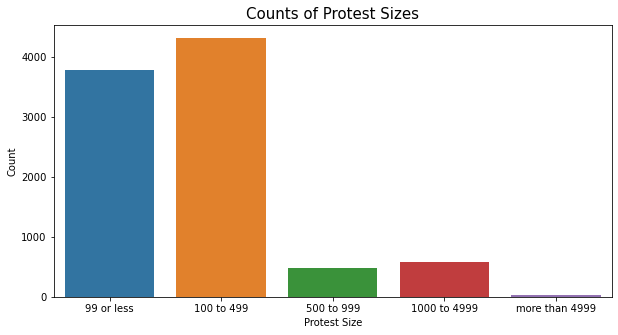

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax = sns.countplot(x="size", 
                   data=protest_df[protest_df["size"] != "unknown"],
                  order = ["99 or less", "100 to 499", "500 to 999", "1000 to 4999", "more than 4999"])
ax.set_title("Counts of Protest Sizes", fontsize = "15")
ax.set_xlabel("Protest Size")
ax.set_ylabel("Count")

In [22]:
protest_df["size"].value_counts()

unknown           7675
100 to 499        4321
99 or less        3789
1000 to 4999       574
500 to 999         489
more than 4999      25
Name: size, dtype: int64

In [23]:
demo_df = pd.read_csv("../processed_data/demographic_data.csv")
demo_df.fips = [str(item).zfill(5) for item in demo_df.fips]
protest_fips = protest_df.fips.unique()

protest_fips_counts = protest_df.fips.value_counts().reset_index()
protest_fips_counts.columns = ["fips", "num"]
protest_fips_counts.sort_values(by = ["num"], inplace = True)

print(f"Of the total {len(demo_df)} FIPS code counties, {len(protest_fips)} had protests and {len(demo_df) - len(protest_fips)}.")

Of the total 1875 FIPS code counties, 1604 had protests and 271.


Text(0.5, 1.0, 'Distribution of Numbers of Protests')

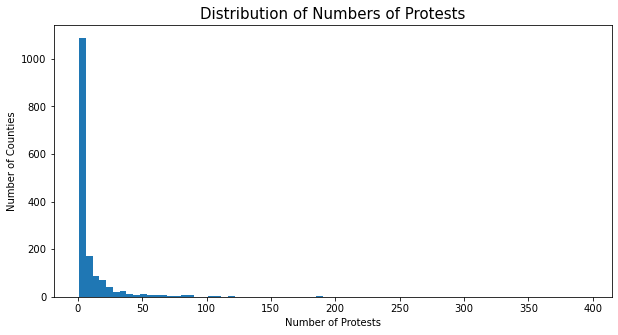

In [24]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(protest_fips_counts["num"], 75)
ax.set_xlabel("Number of Protests")
ax.set_ylabel("Number of Counties")
ax.set_title("Distribution of Numbers of Protests", fontsize = "15")

In [25]:
demo_df = demo_df.merge(protest_fips_counts, on = ["fips"], how = "left")
demo_df = demo_df.rename(columns = {"num":"num_protests"})
demo_df["num_protests"] = demo_df["num_protests"].fillna(0).astype(int)

In [26]:
values = [0, 1, 2]
conditions = [
    (demo_df["num_protests"]==0),
    (demo_df["num_protests"] > 0) & (demo_df["num_protests"] < 6),
    (demo_df["num_protests"] > 5)
]

demo_df["protests"] = np.select(conditions, values)

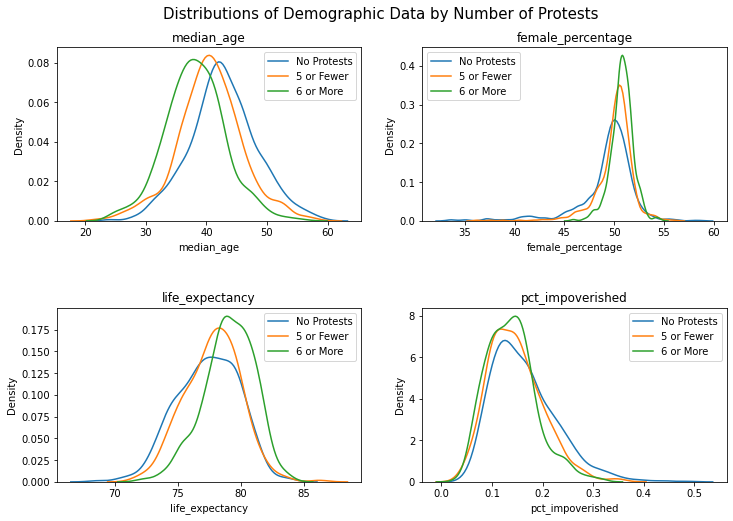

In [27]:
plot_var = ["median_age", "female_percentage", "life_expectancy","pct_impoverished"]

fig, axes = plt.subplots(2,2, figsize = (12,8))

for i, ax in enumerate(axes.ravel()):
    demo_var = plot_var[i]
    sns.kdeplot(data = demo_df[demo_df["protests"] == 0][demo_var], ax = ax, label = "No Protests")
    sns.kdeplot(data = demo_df[demo_df["protests"] == 1][demo_var], ax = ax, label = "5 or Fewer")
    sns.kdeplot(data = demo_df[demo_df["protests"] == 2][demo_var], ax = ax, label = "6 or More")
    ax.set_xlabel(demo_var)
    ax.set_ylabel("Density")
    ax.set_title(demo_var)
fig.suptitle("Distributions of Demographic Data by Number of Protests", y = 0.95, fontsize = "15")
fig.subplots_adjust(hspace = 0.5)

## 4. Model

#### 4.1 Creating the Prediction Dataset

We aggregate the processed COVID-19 data with the demographic data, and create new rows in an augmented dataset including 14-day windows of COVID-19 cases from mid-March as distinct examples.

In [ ]:
covid_df = pd.read_csv("../processed_data/new_confirmed.csv")
demographics_df = pd.read_csv("../processed_data/demographic_data.csv")

df = covid_df.merge(demographics_df, left_on="FIPS", right_on="fips")
df.head()

In [ ]:
WINDOW_SIZE = 15

date_cols = df.columns[1:np.where(df.columns == 'fips')[0][0]]
nondate_cols = df.columns[np.where(df.columns == 'fips')[0][0]:]

augmented_data = []
augmented_index = []
    
for index, row in tqdm(df.iterrows()):
    for i, col in enumerate(date_cols[:-WINDOW_SIZE]):
        series = row[date_cols[i:i+WINDOW_SIZE]].reset_index(drop=True)
        series_dict = {f"{14 - k}_before": v for k, v in series.to_dict().items()}
        series_dict.update(row[nondate_cols].to_dict())
        augmented_data.append(series_dict)
        augmented_index.append(f"{row['fips']}_{date_cols[i+WINDOW_SIZE-1]}")

augmented_df = pd.DataFrame(data=augmented_data, index=augmented_index)
augmented_df = augmented_df[1:]
augmented_df.to_csv("../processed_data/combined.csv")

#### 4.2. Preprocess Data

- We decided to remove rows with null values (given the high abundance of training examples) and to remove rows which included a stray value one day in New York as per https://github.com/CSSEGISandData/COVID-19/issues/3103.
- We assigned the 14-day covid history as separate predictors, as well as a few demographic indicators
- We standardized the data given high variance between the ranges of different features

In [28]:
def num_to_date(i):
    if i>9:
        return str(i)
    return "0" + str(i)

augmented_df = pd.read_csv("../processed_data/combined.csv", index_col=0)

# drop null values
augmented_df = augmented_df.dropna(subset=([f"{k}_before" for k in range(15)]+['pct_impoverished']))

# remove data with spike from NY county https://github.com/CSSEGISandData/COVID-19/issues/3103
augmented_df = augmented_df.drop(["36061_08-31-2020"]+[f"36061_09-{num_to_date(i)}-2020" for i in range(1,15)])

In [29]:
predictors = [f"{k + 1}_before" for k in range(14)] + ['median_age', 'female_percentage', 'life_expectancy', 'pct_impoverished', 'median_hh_income']
X = augmented_df[predictors]
y = augmented_df['0_before']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=209)

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 4.3 Prediction

- We fit a model to the scaled, cleaned data and report MSE and coefficient values

In [31]:
baseline = LinearRegression()
baseline.fit(X_train_scaled, y_train)

y_train_predict = baseline.predict(X_train_scaled)
y_test_predict = baseline.predict(X_test_scaled)

train_mse = mean_squared_error(y_train_predict, y_train)
test_mse = mean_squared_error(y_test_predict, y_test)

print(f"Train MSE: {train_mse}\n Test MSE: {test_mse}\n")

print("Coefficient values")
for coef, col in zip(baseline.coef_, predictors):
    print(f"{col}: {coef}")

Train MSE: 2288.5313032393974
 Test MSE: 1410.6052237455547

Coefficient values
1_before: 9.186384225906911
2_before: 11.279167231486603
3_before: 11.65826457044844
4_before: 6.720346054784471
5_before: 3.993184740551276
6_before: 14.491819623990667
7_before: 15.551266860594618
8_before: 1.1444712812665327
9_before: 0.7076124258939039
10_before: 0.24465294091012116
11_before: 4.072149213933688
12_before: 0.44492963999978585
13_before: -3.469810690790552
14_before: 1.73758436463934
median_age: -0.9844958463607144
female_percentage: 0.489537889308544
life_expectancy: 0.7505754563157763
pct_impoverished: 0.4115103948104874
median_hh_income: 0.600358321184686
